# Master Thesis Script
## ABM environment of Congress Members

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import regex as re
import json
import matplotlib.pyplot as plt
import scipy
import statistics
import math
from fitter import Fitter, get_common_distributions, get_distributions
from statistics import mode
from scipy.stats import nbinom
import ast
import random
import seaborn as sns
from joblib import Parallel, delayed
import statsmodels.api as sm
import pickle
import itertools

This script provides the code for an ABM modelling only the retweets from Congress Members. This is the base model, from which the extended ABM version will be created, modelling retweets from the general public too.

# ABM

In [2]:
# Load the model from the file

with open('logitModel_20230630_NeutralDummy.pkl', 'rb') as file:
    loaded_model_NeutralDummy = pickle.load(file)


All required helper functions are listed below

In [3]:
# rank elements according to overall score
def sort_lists(list1, list2):
    sorted_pairs = sorted(zip(list2, list1), key=lambda x: x[0], reverse=True)
    sorted_list2, sorted_list1 = zip(*sorted_pairs)
    return list(sorted_list1)

In [4]:
def find_bin(value):
    if value < 0 or value > 100:
        return None  # Value is outside the range

    bin_width = 10
    bin_index = value // bin_width

    return bin_index-1

In [5]:
def find_highest_emotion(dictionary, keys):
    for key in keys:
        if key in dictionary and dictionary[key] == 1.0:
            return key

In [6]:
def make_binary_decision(probability):
    random_num = random.random()  # Generate random number between 0 and 1
    if random_num < probability:
        return True
    else:
        return False

In [7]:
def sum_squared_differences(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    squared_diff_sum = 0
    for i in range(len(list1)):
        diff = list1[i] - list2[i]
        squared_diff_sum += diff ** 2
    
    return squared_diff_sum

In [8]:
def is_smaller(variable, values_list):
    for value in values_list:
        if variable < value:
            return True
    return False


In [9]:
def print_bold(text):
    # ANSI escape sequence for bold text
    bold_start = "\033[1m"
    bold_end = "\033[0m"

    # Print the text in bold
    print(bold_start + text + bold_end)

In [10]:
class Environment:
    
    def __init__(self, NG_df_recent, pol_network_dict, loaded_model_final, timeline_length, recency_boost, rt_boost, alignment_boost, misalignment_downgrade, misinfo_downgrade, anger_boost):
        """
        This method is executed when an instance of this class is created.
        We enable access to the input variables across all methods of this class.
        
        """
    
        self.NG_df_recent = NG_df_recent
        self.pol_network_dict = pol_network_dict  
        self.loaded_model_final = loaded_model_final
        self.timeline_length = timeline_length
        self.recency_boost = recency_boost
        self.rt_boost = rt_boost
        self.alignment_boost = alignment_boost
        self.misalignment_downgrade = misalignment_downgrade
        self.misinfo_downgrade = misinfo_downgrade
        self.anger_boost = anger_boost
        
    def setup(self):
        """
        This method sets up the initial state of the simulation by initializing the counter of timesteps with 0.
        """
       
        self.step_counter = 0
     
    
    
    def post_tweets(self):
        """
        This method goes through all agents in the model in each timestep, matches them with tweets posted by
        the according politician in the observed data and in line with the politician's assigned tweeting frequency, 
        lets them post a given number of tweets. Once posted, these tweets are marked as having been tweeted, in the
        total tweet dataset.
        
        """
        tweet_lst = []
        

        for pol_entry in self.pol_network_dict:
            
            politician = pol_entry["Politician_ID"]
            
            tweet_frequency = int(round((pol_entry["Tweet_Frequency_Day"]*0.25),0))
            if tweet_frequency == 0:
                tweet_frequency = 1
          
            row_indices = self.NG_df_recent.index[(self.NG_df_recent["author_id_new"] == politician) & (self.NG_df_recent["tweeted"] != 1)].tolist()
            num_row_indices = len(row_indices)
            if num_row_indices >= 1 and num_row_indices >= tweet_frequency: 
        
            # take random indices from the matched rows, matching the number of tweets per day by given CM
                random_tweet_indices = random.sample(row_indices, tweet_frequency)
            # Extract the matched row to a dictionary
            elif num_row_indices >= 1 and num_row_indices < tweet_frequency:
                random_tweet_indices = row_indices
            else:
                continue
             
            indices_to_use = random_tweet_indices
          
            tweets = self.NG_df_recent.iloc[indices_to_use].to_dict('records')
            tweet_lst.extend(
                [
                    {**tweet, "timestep_posted": self.step_counter, "Simulated_retweet_count": 0}
                    for tweet in tweets
                ])
            self.NG_df_recent.loc[indices_to_use, "tweeted"] = 1
        
        self.tweet_lst = tweet_lst
        print("Number of Tweets posted: ")
        print(len(self.tweet_lst))
        
       
          
    def add_posted_tweets(self):
        """
        This method adds the posted tweets to the feed of the posting politicians' followers
        
        """
        
        for tweet in self.tweet_lst:
            tweet["timestep_received"] = self.step_counter
            matched_dict = next((item for item in self.pol_network_dict if item['Politician_ID'] == tweet["author_id_new"]), None)
            if matched_dict:
                pol_followers = ast.literal_eval(matched_dict["politician_followers"])
                pol_followers_set = set(pol_followers)
                self.pol_network_dict = [
                    {**pol_dict, "Twitter_feed": self.add_tweet_to_feed(pol_dict, tweet)}
                    if pol_dict["Politician_ID"] in pol_followers_set
                    else pol_dict for pol_dict in self.pol_network_dict  ]
                             
                            
    def add_retweeted_tweet(self):
        """
        This method has the same logic as the above method, but adds retweets (instead of original tweets)
        to user feeds.
        
        """
        retweet_lst = self.retweet_df.to_dict('records')
       
        for tweet in retweet_lst:
            tweet["timestep_received"] = self.step_counter
        # extract list of followers of tweet author
            matched_dict = next((item for item in self.pol_network_dict if item['Politician_ID'] == tweet["Retweeting_Politician_ID"]), None)
           
            pol_followers = matched_dict["politician_followers"]
            pol_followers = ast.literal_eval(pol_followers)
            pol_followers_set = set(pol_followers)
    # now for each politician follower, in the pol_network_2 df add the tweet to their Twitter_feed column
    
        for i, pol_dict in enumerate(self.pol_network_dict):
                if pol_dict["Politician_ID"] in pol_followers_set:
            # if follower politician does not have any tweets in their timeline yet, just add the tweet
            # need to remove duplicates of tweets added to timeline in the same timestep
                    if not isinstance(pol_dict["Twitter_feed"], list):
                        self.pol_network_dict[i]["Twitter_feed"] = [tweet]
                        
                        
                    else:
                # if the timeline already has some tweets, need to ensure we don't already have the tweet in the timeline
                        #is_present = any(dictionary["id"] == tweet["id"] for dictionary in pol_dict["Twitter_feed"])
                        tweet_ids = set(dictionary["id"] for dictionary in pol_dict["Twitter_feed"])
                        is_present = tweet["id"] in tweet_ids
                        if not is_present:
                     # if it is not already in the timeline, add it
                            
                            
                            self.pol_network_dict[i]["Twitter_feed"].append(tweet)
                            
        
        
    def apply_ranking_algorithm(self, pol_dict):
        """
        This method is responsible for the order in which tweets are ranked in each user's feed.
        This matters because the assumption is made that users have a limited capacity of viewing and thus
        deciding upon retweeting of tweets in their feeds in a given timestep.
        Therefore, after ranking, tweets beyond a certain rank are removed and will not be considered for retweeting.
        In the base version of this model, tweets are only ranked in terms of the recency of their posting time, i.e.,
        in reverse chronological order.
        
        Parameters:
        This method takes as input the dictionary of each politician, which contains information on their
        follower count, Party and current Twitter feed, among other variables.
        
        Returns:
        The method returns the ranked Twitter feed, which has been cut off after the specified maximum number 
        of tweets to be considered.
        
        """
        follower_party = pol_dict["Party"]
        tweets = pol_dict["Twitter_feed"]
        
        authors_follower_count = []
        
        if not isinstance(tweets, list):
            return None
        
        for tweet in tweets:
            authors_follower_count.append(tweet["Follower_count"])
       
        tweet_score_lst = [self.recency_boost if tweet["timestep_posted"] == self.step_counter else 0 for tweet in tweets]
        ranked_tweets = sort_lists(tweets, tweet_score_lst)
        
        
        for idx, tweet_item in enumerate(ranked_tweets):
            timestep_posted = tweet_item["timestep_posted"] 
            timestep_received = tweet_item["timestep_received"]
           
            if timestep_posted < self.step_counter: 
                if timestep_received == self.step_counter:
                    timesteps_demote = self.step_counter-timestep_posted
                    ranked_tweets.insert(idx + timesteps_demote, ranked_tweets.pop(idx))#timesteps_demote
                elif timestep_received < self.step_counter:
                    ranked_tweets.insert(idx + 1, ranked_tweets.pop(idx))
        ranked_tweets = ranked_tweets[:self.timeline_length]
    
        pol_dict["Twitter_feed_ranked"] = ranked_tweets
        
        
        return pol_dict["Twitter_feed_ranked"]

    def create_retweet_records(self, pol_dict, tweet):
        new_row = {'Retweeting_Politician_ID': pol_dict["Politician_ID"], 'id': tweet["id"], "timestep_posted": tweet["timestep_posted"]}
        return new_row
    
    def retweet_decision_logit(self, pol_dict):
        """
        This method lets the respective politician decide upon retweeting, for each tweet in the ranked feed created
        with the above method.
        For the retweeting decision, the previously estimated logistic regression model is used, while a binary decision is 
        then made based on the predicted probability, introducing some randomness.
        If the given politician decides to retweet, the retweet is multiplied by using the number of estimated followers
        with the same political ideology as the politician and making a random draw from this number, using a binomial 
        distribution.
        Finally, the intersection of followers between tweeting and retweeting politician is considered here,
        this overlap increasing the final retweet count due to complex contagion (a user seeing a given post several times).
        
        Parameters:
        This method takes as input the dictionary of each politician, which contains information on their
        follower count, Party and current Twitter feed, among other variables.
        
        Returns:
        The method returns a df of the retweets made by the respective politician in that timestep.
        These retweets are then added to the follower feeds in the next timestep.
        
        """
        follower_party = pol_dict["Party"]
        ranked_feed = pol_dict["Twitter_feed_ranked"]
        
        if isinstance(ranked_feed, list) == False:
            return None
        
        friends = pol_dict["Friend_count"]
        friend_foll_intersect_str = pol_dict["fol_friend_intersect"]
        foll_foll_intersect_str = pol_dict["fol_fol_intersect"]
        
        if self.step_counter > 0:
            key_to_drop = "Retweeted"
            key_to_drop_2 = "Read"
            value_to_drop = True

            # Drop dictionaries with the specified key value
            ranked_feed = [d for d in ranked_feed if d.get(key_to_drop) != value_to_drop]
            ranked_feed = [d for d in ranked_feed if d.get(key_to_drop_2) != value_to_drop]
        if len(ranked_feed)<1:
            return None
        
        author_ids = []
        for tweet in ranked_feed:
                
                author_ids.append(tweet["author_id_new"])
                
        intersect_lsts = [friend_foll_intersect_str, foll_foll_intersect_str]
        if isinstance(friend_foll_intersect_str, list):
            friend_foll_intersect = ast.literal_eval(friend_foll_intersect_str)
          
            for item in friend_foll_intersect:
                for key, value in item.items():
                    if value is None:
                        item[key] = 0
                        
            # get share of friend-follower intersection for each tweet with the given CM
                
            authors_intersection_lst = []
            friend_foll_dict = {item['author_id']: item['intersection'] for item in friend_foll_intersect}

            for author_id in author_ids:
                if author_id in friend_foll_dict:
                    intersection = friend_foll_dict[author_id]
                    authors_intersection_lst.append(intersection/friends)
                else:
                    authors_intersection_lst.append(0)
        else:
            authors_intersection_lst = [0] * len(ranked_feed)
        # if we already did a round, need to exclude tweets that this CM has already retweeted
        
        number_followers_generalpublic = pol_dict["Follower_count"]
        
        
    
        tweet_df = pd.DataFrame(ranked_feed)
        tweet_df["Same_Party_Dummy"] = 0
        tweet_df.loc[tweet_df["Party"] == follower_party, "Same_Party_Dummy"] = 1
        tweet_df['Interaction_fear_SameParty'] = tweet_df['Fear']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_happiness_SameParty'] = tweet_df['Happiness']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_sadness_SameParty'] = tweet_df['Sadness']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_SameParty_NG'] = tweet_df['NG_score']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_Outgroup_SameParty'] = tweet_df['Number_Outgroup_Words_log']*tweet_df['Same_Party_Dummy']
        tweet_df['Interaction_Ingroup_SameParty'] = tweet_df['Number_Ingroup_Words_log']*tweet_df['Same_Party_Dummy']
         
                    
            # add this to the df column
            
        tweet_df["Friend_Follower_Intersection_Share"] = authors_intersection_lst
         
        X = tweet_df[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log','Interaction_fear_SameParty', 'Interaction_happiness_SameParty',
                             'Interaction_sadness_SameParty', 'Interaction_SameParty_NG',                             
                             'Interaction_Outgroup_anger','Interaction_Ingroup_anger',
                             'Interaction_Outgroup_fear', 'Interaction_Outgroup_happiness',
                      'Interaction_Outgroup_SameParty', 'Interaction_Ingroup_SameParty'
                             ]]
        X.insert(0, 'Constant', 1)
 
        predicted_prob_logit = self.loaded_model_final.predict(X).values.tolist()
          
        predicted_prob = [item *0.1 for item in predicted_prob_logit]# change later
        tweet_df["Predicted_prob"] = predicted_prob
            
            # increase the predicted probability by our friend-follower overlap
            
        tweet_df["Predicted_prob"] = tweet_df["Predicted_prob"] * (1+tweet_df["Friend_Follower_Intersection_Share"])
        
            # make a binary decision based on this predicted probability value
            
        tweet_df["decision_RT"] = tweet_df["Predicted_prob"].apply(lambda x: make_binary_decision(x))
        tweet_df["Read"] = True
        tweet_df_RT = tweet_df[tweet_df["decision_RT"] == True]
            # record which tweets the CM retweeted
        retweeted_tweets = tweet_df_RT["id"].values.tolist()
        for tweet_in_feed in pol_dict["Twitter_feed"]:
            # Check if the value in the selected column matches the value_to_match
            if tweet_in_feed["id"] in retweeted_tweets:
            # Update the selected key with a new value
                tweet_in_feed["Retweeted"] = True
                
            # Check if the value in df1["Flag"] is equal to 1
        mask = tweet_df["decision_RT"] == True
          
            # Update NG_df RT counts
        self.NG_df_recent.loc[self.NG_df_recent["id"].isin(tweet_df.loc[mask, "id"]), "Simulated_retweet_count"] += 1
        retweet_records_df_1 = pd.DataFrame()
            
        retweet_records_df_1["id"] = tweet_df_RT["id"]
        retweet_records_df_1["timestep_posted"] = tweet_df_RT["timestep_posted"]
        retweet_records_df_1['Retweeting_Politician_ID'] = pol_dict["Politician_ID"]
           
        retweet_records = retweet_records_df_1.to_dict("records")
        
        if len(retweet_records) > 0:
            return retweet_records
        else:
            return None

            
    def add_tweet_to_feed(self, pol_dict, tweet):
        if not isinstance(pol_dict["Twitter_feed"], list):
            pol_dict["Twitter_feed"] = [tweet]
        
        else: 
            pol_dict["Twitter_feed"].append(tweet)
       
        return pol_dict["Twitter_feed"]

    

    def step(self):
        """
        This method performs a single timestep in the model, triggering all necessary methods,
        while updating the state of the environment and printing the timestep and number of retweets
        in each timestep.
        The methods excuted in this method include posting of tweets, retweeting of tweets (if the timestep is larger than 0),
        adding posted tweets and retweets to user feeds, applying the platform ranking algorithm, letting users decide on 
        whether to retweet or not and finally, updating the tweet dataset with the retweeting records.
        
        """
        # Perform one time step of the model
        # Update the state of the environment and agents
        print_bold("Time Step: ")
        print(self.step_counter)
        self.post_tweets()
 
        self.add_posted_tweets()
        # only if we are beyond the first timestep, do we also look at retweets
        if self.step_counter > 0:
            self.add_retweeted_tweet()
   
        
        for i, pol_dict in enumerate(self.pol_network_dict):
            item_check = self.apply_ranking_algorithm(pol_dict)
            if not isinstance(item_check, list):
                self.pol_network_dict[i]["Twitter_feed_ranked"] = None
            else:
                self.pol_network_dict[i]["Twitter_feed_ranked"] = item_check
        total_retweet_records = []
        for i, pol_dict in enumerate(self.pol_network_dict):
   
            retweet_records = self.retweet_decision_logit(pol_dict)
           
            if isinstance(retweet_records, list):
                total_retweet_records.append(retweet_records)
            
        flat_list = [item for sublist in total_retweet_records for item in sublist]
        retweet_records_df = pd.DataFrame(flat_list)
        if len(retweet_records_df) == 0:
            return
        retweet_df = pd.merge(retweet_records_df, self.NG_df_recent, on='id', how='left')
        #retweet_df = retweet_df[["id", "timestep_posted", "Retweeting_Politician_ID"]]
        
        self.retweet_df = retweet_df
        print("Number of RTs: ")
        print(len(self.retweet_df))
        self.step_counter += 1

    def run(self, num_steps):
        # Run the simulation for a given number of time steps
        for _ in range(num_steps):
            if self.step_counter > 0:
                count = (self.NG_df_recent["tweeted"] == 0).sum()
              
                # if every tweet has been tweeted, then check if number of RTs are sufficiently low to stop the simulation
                if count ==0:    
                    if len(self.retweet_df) ==1:
                        break
                    else:
                        self.step()
                else:
                    self.step()
            else:
                self.step()
      
            
        return self.NG_df_recent

 


In [11]:
# load required data
NG_df_recent_RTs = pd.read_csv("Data_RTs_CM_ABM_20230630_Model1.csv")
NG_df_recent_NoRTs = pd.read_csv("Data_RTs_CM_ABM_20230630_Model1_No_RTs.csv")
pol_network_merged =pd.read_csv("pol_network_merged.csv")
pol_network_dict = pol_network_merged.to_dict(orient='records')
NG_df_recent_RTs = NG_df_recent_RTs.drop('Unnamed: 0', axis=1)
NG_df_recent_NoRTs = NG_df_recent_NoRTs.drop('Unnamed: 0', axis=1)
NG_df_recent_RTs = NG_df_recent_RTs.rename(columns={"Party_retweeted_author":"Party"})
NG_df_recent = pd.concat([NG_df_recent_RTs, NG_df_recent_NoRTs], axis=0)

In [12]:
NG_df_recent["Simulated_retweet_count"] = 0
NG_df_recent["tweeted"] = np.nan

In [13]:
NG_df_recent['NG_score_bins'] = pd.cut(NG_df_recent['NG_score'], 5)

In [14]:
# Set the random seed (optional)
random_seed = 42

# Take a random sample of rows from the dataframe
sample_size = 10000
NG_df_recent_sample = NG_df_recent.sample(n=sample_size)
NG_df_recent_sample.reset_index(inplace=True)

In [15]:
timeline_length = 20
recency_boost = 10
rt_boost = 10
alignment_boost = 10
misalignment_downgrade = 5
misinfo_downgrade = 1
anger_boost = 0

In [16]:
env = Environment(NG_df_recent_sample, pol_network_dict, loaded_model_NeutralDummy, timeline_length, recency_boost, rt_boost, alignment_boost, misalignment_downgrade, misinfo_downgrade, anger_boost)
env.setup()

NG_df_recent_updated = env.run(num_steps=120)

Time Step: 
0
Number of Tweets posted: 
809
Number of RTs: 
847
Time Step: 
1
Number of Tweets posted: 
738
Number of RTs: 
252
Time Step: 
2
Number of Tweets posted: 
677
Number of RTs: 
259
Time Step: 
3
Number of Tweets posted: 
612
Number of RTs: 
239
Time Step: 
4
Number of Tweets posted: 
560
Number of RTs: 
238
Time Step: 
5
Number of Tweets posted: 
508
Number of RTs: 
238
Time Step: 
6
Number of Tweets posted: 
461
Number of RTs: 
212
Time Step: 
7
Number of Tweets posted: 
417
Number of RTs: 
228
Time Step: 
8
Number of Tweets posted: 
382
Number of RTs: 
207
Time Step: 
9
Number of Tweets posted: 
346
Number of RTs: 
207
Time Step: 
10
Number of Tweets posted: 
319
Number of RTs: 
207
Time Step: 
11
Number of Tweets posted: 
289
Number of RTs: 
189
Time Step: 
12
Number of Tweets posted: 
270
Number of RTs: 
188
Time Step: 
13
Number of Tweets posted: 
256
Number of RTs: 
183
Time Step: 
14
Number of Tweets posted: 
242
Number of RTs: 
184
Time Step: 
15
Number of Tweets pos

In [17]:
observed_tweets = NG_df_recent_updated.loc[NG_df_recent_updated["tweeted"] == 1, "RT_count"].values
observed_tweets_log = [np.log(item + 1) for item in observed_tweets]
sim_tweets = NG_df_recent_updated.loc[NG_df_recent_updated["tweeted"] == 1, "Simulated_retweet_count"].values
sim_tweets_log = [np.log(item + 1) for item in sim_tweets]

In [18]:
# report moments
# means
print(sum(observed_tweets)/len(observed_tweets))
print(sum(sim_tweets)/len(sim_tweets))
# median
print(statistics.median(observed_tweets))
print(statistics.median(sim_tweets))
#variance
print(np.var(observed_tweets))
print(np.var(sim_tweets))
# skewness
print(scipy.stats.skew(observed_tweets))
print(scipy.stats.skew(sim_tweets))
# kurtosis
print(scipy.stats.kurtosis(observed_tweets))
print(scipy.stats.kurtosis(sim_tweets))

0.8050100200400802
0.7056112224448898
1.0
1.0
1.0842233966931862
0.8323733238019123
12.260367009696092
10.033234418694587
243.94420524747608
173.40596851837273


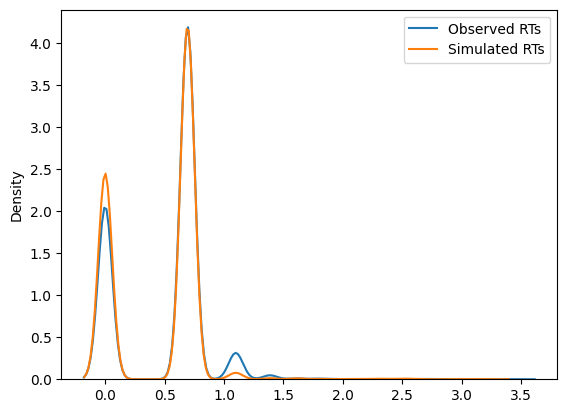

In [19]:

# Plot kernel density curve using seaborn
result_lst = [observed_tweets_log, sim_tweets_log]
#for item in result_lst:
 #   sns.kdeplot(item, label)
sns.kdeplot(observed_tweets_log, label='Observed RTs')
sns.kdeplot(sim_tweets_log, label='Simulated RTs')

# Add legend
plt.legend()

# Display the plot
plt.show()

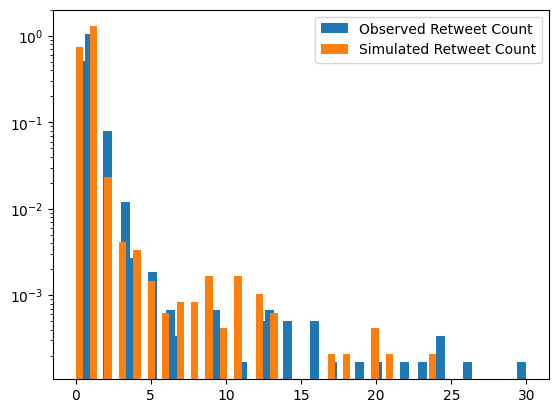

In [20]:

# Plot kernel density curve using seaborn
result_lst = [observed_tweets_log, sim_tweets_log]

plt.hist(observed_tweets, bins=50,density=True, label="Observed Retweet Count")
plt.hist(sim_tweets, bins=50,density=True, label="Simulated Retweet Count")


plt.yscale('log')
# Add legend
plt.legend()

# Display the plot
plt.show()

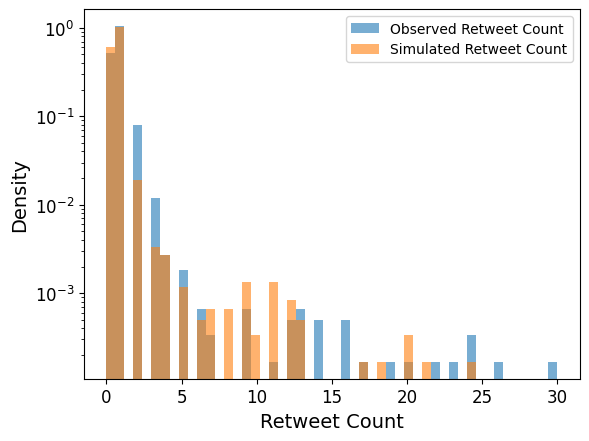

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# Combine the observed and simulated data into a single list
all_tweets = observed_tweets + sim_tweets

# Calculate the common bin edges
num_bins = 50
bin_edges = np.linspace(min(all_tweets), max(all_tweets), num_bins + 1)

# Plot the histograms with the common bin edges
plt.hist(observed_tweets, bins=bin_edges, density=True, alpha=0.6, label="Observed Retweet Count")
plt.hist(sim_tweets, bins=bin_edges, density=True, alpha=0.6, label="Simulated Retweet Count")

# Use a logarithmic scale on the y-axis
plt.yscale('log')
# Add legend
# Set tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend()


# Set axis labels and title (optional)
plt.xlabel("Retweet Count", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.savefig('Figures/hist_plot_final_CM.svg', format='svg')
# Display the plot
plt.show()

In [22]:
NG_df_results = NG_df_recent_updated[NG_df_recent_updated["tweeted"] == 1]


In [23]:
NG_df_results.loc[:,"Sim_incr"] =NG_df_results.loc[:,"Simulated_retweet_count"]+1
NG_df_results.loc[:,"Observed_incr"] = NG_df_results.loc[:,"RT_count"]+1
NG_df_results.loc[:,"Sim_log"] = np.log(NG_df_results.loc[:,"Sim_incr"])
NG_df_results.loc[:,"Observed_log"] = np.log(NG_df_results.loc[:,"Observed_incr"])

/tmp/ipykernel_31114/581742050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_results.loc[:,"Sim_incr"] =NG_df_results.loc[:,"Simulated_retweet_count"]+1
/tmp/ipykernel_31114/581742050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_results.loc[:,"Observed_incr"] = NG_df_results.loc[:,"RT_count"]+1
/tmp/ipykernel_31114/581742050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [24]:

bin_edges = [0, 20, 40, 60, 80, 100]

# Create bins based on NG_score using custom bin edges
NG_df_results['NG_score_bins'] = pd.cut(NG_df_results['NG_score'], bins=bin_edges)
NG_grouped_sim = NG_df_results.groupby('NG_score_bins', as_index=False)['Simulated_retweet_count'].mean()

/tmp/ipykernel_31114/1188931348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_results['NG_score_bins'] = pd.cut(NG_df_results['NG_score'], bins=bin_edges)


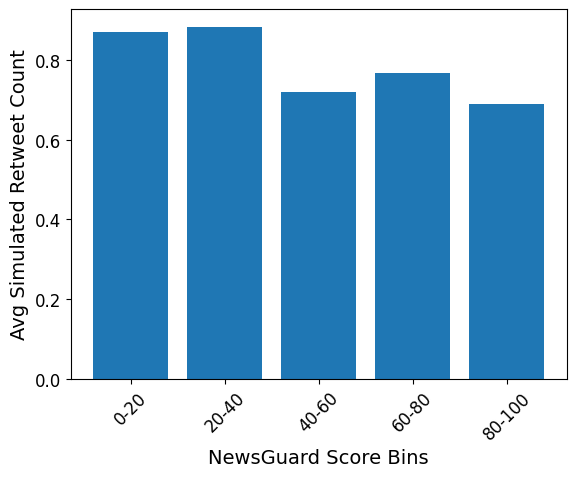

In [25]:
x_labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

# Plot bar chart using matplotlib
plt.bar(range(len(NG_grouped_sim)), NG_grouped_sim["Simulated_retweet_count"])

# Set x-axis labels and their positions
plt.xticks(range(len(NG_grouped_sim)), x_labels, fontsize=12, rotation=45)

# Set x-axis label with increased font size
plt.xlabel('NewsGuard Score Bins', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Avg Simulated Retweet Count', fontsize=14)

# Set tick labels font size
plt.yticks(fontsize=12)


plt.savefig('Figures/NGscore_sim_final_CM.svg', bbox_inches='tight',format='svg')
# Display the plot
plt.show()

In [26]:
NG_grouped_sim_log = NG_df_results.groupby('NG_score_bins', as_index=False)['Sim_log'].count()

In [27]:
print(NG_grouped_sim_log)

  NG_score_bins  Sim_log
0       (0, 20]       70
1      (20, 40]       26
2      (40, 60]      147
3      (60, 80]     1595
4     (80, 100]     8142


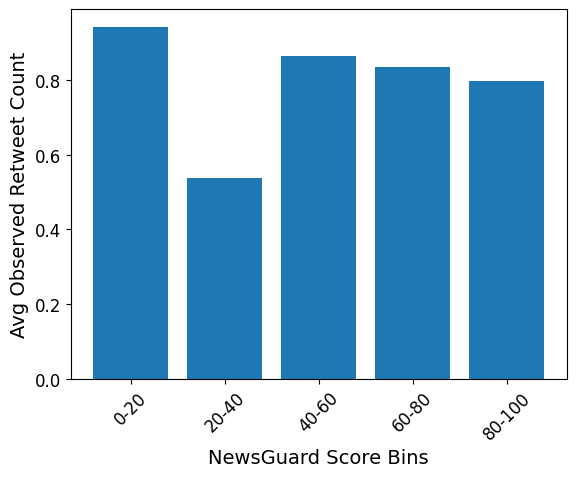

In [28]:
NG_grouped_obs_log = NG_df_results.groupby('NG_score_bins', as_index=False)['RT_count'].mean()
x_labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

# Plot bar chart using matplotlib
plt.bar(range(len(NG_grouped_obs_log)), NG_grouped_obs_log["RT_count"])

# Set x-axis labels and their positions
plt.xticks(range(len(NG_grouped_obs_log)), x_labels, fontsize=12, rotation=45)

# Set x-axis label with increased font size
plt.xlabel('NewsGuard Score Bins', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Avg Observed Retweet Count', fontsize=14)

# Set tick labels font size
plt.yticks(fontsize=12)
plt.savefig('Figures/NGscore_obs_final_CM.svg',  bbox_inches='tight',format='svg')
# Display the plot
plt.show()